In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier

from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.svm import SVC
from sklearn import metrics

from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_auc_score, precision_score, recall_score


# 思路一：
PCA降维处理+K-means++聚类
PCA降维为7个主成分，经过轮廓分析后发现聚为7类效果最好。故放弃

In [2]:
data = pd.read_excel('excel/extract/2/铅钡_min-max.xlsx')
data.head()

,二氧化硅(SiO2)_min-max标准化,氧化钠(Na2O)_min-max标准化,氧化钾(K2O)_min-max标准化,氧化钙(CaO)_min-max标准化,氧化镁(MgO)_min-max标准化,氧化铝(Al2O3)_min-max标准化,氧化铁(Fe2O3)_min-max标准化,氧化铜(CuO)_min-max标准化,氧化铅(PbO)_min-max标准化,氧化钡(BaO)_min-max标准化,...,五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),量化风化,纹饰,颜色,类型,表面风化,总和
0,0.453545,0.000822,0.743344,0.336669,0.431749,0.380130,0.404892,0.014340,0.626006,0.000000,...,3.57,0.19,0.003644,0.028675,2,2,2,铅钡,风化,100.00
1,0.228723,0.014450,0.000000,0.196161,0.005499,0.064075,0.002392,0.984704,0.318174,0.880765,...,3.59,0.37,0.013985,2.580000,2,1,3,铅钡,风化,100.00
2,0.012397,0.157298,0.054390,0.475544,0.058644,0.047516,0.027908,0.289675,0.380069,0.863530,...,7.56,0.53,0.126256,15.030000,2,1,3,铅钡,风化,100.00
3,0.416075,0.110638,0.144480,0.527826,0.259441,0.161267,0.026391,0.460803,0.264160,0.411172,...,9.38,0.37,0.077115,0.910942,2,1,2,铅钡,风化,97.39
4,0.361053,0.045676,0.032856,0.433065,0.215447,0.224622,0.289358,0.325048,0.550320,0.149533,...,8.83,0.19,0.055317,0.756598,2,2,2,铅钡,风化,100.00


In [3]:
# data2 = data.loc[:, '二氧化硅(SiO2)_min-max标准化':'二氧化硫(SO2)_min-max标准化']
data2 = data.loc[:, '二氧化硅(SiO2)':'二氧化硫(SO2)']
length = data2.shape[0]
width = data2.shape[1]
# for i in range(length):
#     for j in range(width):
#         data2.iloc[i,j]
print(length)
print(width)

49
14


In [4]:
F_list=[]
F1_list =[]
F2_list =[]
F3_list =[]
F4_list =[]
F5_list =[]
F6_list =[]
F7_list =[]
for i in range(length):
    # 铅钡
    F1=0.215*data2.iloc[i,0]+0.073*data2.iloc[i,1]+0.091*data2.iloc[i,2]-0.029*data2.iloc[i,3]+0.134*data2.iloc[i,4]+0.18*data2.iloc[i,5]+0.111*data2.iloc[i,6]-0.161*data2.iloc[i,7]-0.137*data2.iloc[i,8]-0.178*data2.iloc[i,9]-0.098*data2.iloc[i,10]-0.133*data2.iloc[i,11]+0.13*data2.iloc[i,12]-0.144*data2.iloc[i,13]
    F2=-0.164*data2.iloc[i,0]-0.161*data2.iloc[i,1]+0.117*data2.iloc[i,2]+0.28*data2.iloc[i,3]+0.194*data2.iloc[i,4]+0.061*data2.iloc[i,5]+0.166*data2.iloc[i,6]-0.093*data2.iloc[i,7]+0.178*data2.iloc[i,8]-0.122*data2.iloc[i,9]+0.228*data2.iloc[i,10]+0.102*data2.iloc[i,11]+0.065*data2.iloc[i,12]-0.029*data2.iloc[i,13]
    F3=-0.036*data2.iloc[i,0]+0.004*data2.iloc[i,1]+0.259*data2.iloc[i,2]+0.142*data2.iloc[i,3]+0.031*data2.iloc[i,4]+0.214*data2.iloc[i,5]+0.153*data2.iloc[i,6]+0.235*data2.iloc[i,7]-0.349*data2.iloc[i,8]+0.372*data2.iloc[i,9]+0.05*data2.iloc[i,10]-0.065*data2.iloc[i,11]+0.215*data2.iloc[i,12]+0.328*data2.iloc[i,13]
    F4=-0.07*data2.iloc[i,0]+0.415*data2.iloc[i,1]-0.404*data2.iloc[i,2]+0.029*data2.iloc[i,3]+0.305*data2.iloc[i,4]+0.277*data2.iloc[i,5]-0.343*data2.iloc[i,6]+0.011*data2.iloc[i,7]-0.033*data2.iloc[i,8]-0.001*data2.iloc[i,9]+0.083*data2.iloc[i,10]+0.433*data2.iloc[i,11]+0.323*data2.iloc[i,12]+0.066*data2.iloc[i,13]
    F5=-0.106*data2.iloc[i,0]+0.306*data2.iloc[i,1]+0.342*data2.iloc[i,2]-0.082*data2.iloc[i,3]-0.134*data2.iloc[i,4]-0.232*data2.iloc[i,5]+0.069*data2.iloc[i,6]-0.607*data2.iloc[i,7]+0.244*data2.iloc[i,8]+0.005*data2.iloc[i,9]-0.312*data2.iloc[i,10]+0.179*data2.iloc[i,11]+0.194*data2.iloc[i,12]+0.527*data2.iloc[i,13]
    F6=0.018*data2.iloc[i,0]+0.588*data2.iloc[i,1]+0.4*data2.iloc[i,2]-0.05*data2.iloc[i,3]+0.287*data2.iloc[i,4]-0.122*data2.iloc[i,5]+0.22*data2.iloc[i,6]+0.224*data2.iloc[i,7]-0.097*data2.iloc[i,8]-0.021*data2.iloc[i,9]+0.084*data2.iloc[i,10]+0.307*data2.iloc[i,11]-0.602*data2.iloc[i,12]-0.145*data2.iloc[i,13]
    F7=-0.086*data2.iloc[i,0]-0.186*data2.iloc[i,1]+0.245*data2.iloc[i,2]-0.195*data2.iloc[i,3]-0.147*data2.iloc[i,4]+0.075*data2.iloc[i,5]+0.21*data2.iloc[i,6]+0.322*data2.iloc[i,7]+0.228*data2.iloc[i,8]+0.152*data2.iloc[i,9]-0.497*data2.iloc[i,10]+0.524*data2.iloc[i,11]+0.378*data2.iloc[i,12]-0.478*data2.iloc[i,13]

    F=(0.269/0.846)*F1+(0.212/0.846)*F2+(0.113/0.846)*F3+(0.077/0.846)*F4+(0.061/0.846)*F5+(0.06/0.846)*F6+(0.056/0.846)*F7

    F_list.append(F)
    F1_list.append(F1)
    F2_list.append(F2)
    F3_list.append(F3)
    F4_list.append(F4)
    F5_list.append(F5)
    F6_list.append(F6)
    F7_list.append(F7)


In [5]:
pred = {
    'F':F_list,
    'F1': F1_list,
    'F2': F2_list,
    'F3': F3_list,
    'F4': F4_list,
    'F5': F5_list,
    'F6': F6_list,
    'F7': F7_list,
    '量化风化': data['量化风化'],
    '表明风化': data['表面风化']
}

pred_first = pd.DataFrame(pred)
pred_first.to_excel('./excel/result/2/data_PCA_铅钡.xlsx')
pred_first.head()


,F,F1,F2,F3,F4,F5,F6,F7,量化风化,表明风化
0,0.249126,2.296511,4.956188,-15.448570,-2.759241,5.319902,-3.175213,6.543503,2,风化
1,-1.747573,-7.392638,-1.711718,4.836194,-1.175196,-1.383133,-0.862253,9.877913,2,风化
2,-1.424613,-12.126754,3.163932,6.680292,1.392722,11.239184,-3.908858,1.302672,2,风化
3,-0.467379,-0.165259,0.111441,-1.543607,-0.820923,-3.305018,-0.004096,1.159230,2,风化
4,-0.449282,-1.186987,5.115486,-11.089806,-1.640121,1.968056,-2.167528,4.360020,2,风化


# 思路二（最终）:
直接K-means++聚类

In [6]:
data = pd.read_excel('excel/extract/2/铅钡.xlsx')
data.head()

,文物采样点,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),...,五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),量化风化,纹饰,颜色,类型,表面风化,总和
0,02,36.28,0.020016,1.050000,2.34,1.180000,5.73,1.860000,0.26,47.43,...,3.57,0.19,0.003644,0.028675,2,2,2,铅钡,风化,100.00
1,08,20.14,0.127769,0.007344,1.48,0.017329,1.34,0.013572,10.41,28.68,...,3.59,0.37,0.013985,2.580000,2,1,3,铅钡,风化,100.00
2,08严重风化点,4.61,1.257193,0.083635,3.19,0.162292,1.11,0.130625,3.14,32.45,...,7.56,0.53,0.126256,15.030000,2,1,3,铅钡,风化,100.00
3,11,33.59,0.888276,0.210000,3.51,0.710000,2.69,0.123667,4.93,25.39,...,9.38,0.37,0.077115,0.910942,2,1,2,铅钡,风化,97.39
4,19,29.64,0.374655,0.053430,2.93,0.590000,3.57,1.330000,3.51,42.82,...,8.83,0.19,0.055317,0.756598,2,2,2,铅钡,风化,100.00


In [7]:
x = data.loc[:, '二氧化硅(SiO2)':'量化风化']
print(x.shape)
scaler = StandardScaler()
x = scaler.fit_transform(x)
plt.rcParams['font.sans-serif']=['SimHei']


plt.rcParams['axes.unicode_minus'] = False

(49, 15)


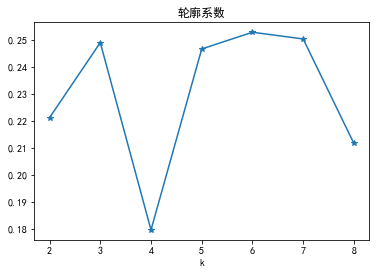

In [8]:
#肘部法
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
inertia=[]
si1_score=[]
for k in range(2,9) :
    kmeans=KMeans(n_clusters=k, random_state=0).fit(x)
    inertia.append(np.sqrt(kmeans.inertia_))
    si1_score.append(silhouette_score(x,kmeans.labels_))
plt.plot(range(2,9) , si1_score, '*-')
plt.xlabel('k')
plt.title('轮廓系数')
plt.savefig('./excel/result/2/轮廓系数.png')
plt.show()

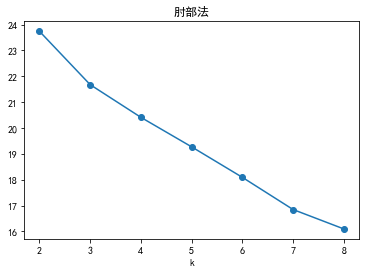

In [9]:
plt.plot(range(2,9) , inertia, 'o-')
plt.xlabel('k')
plt.title('肘部法')
plt.savefig('./excel/result/2/肘部法.png')
plt.show()


In [10]:
model = KMeans(n_clusters=6, max_iter=100, init="k-means++")
model.fit(x)

KMeans(max_iter=100, n_clusters=6)

c:\Miniconda\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Miniconda\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


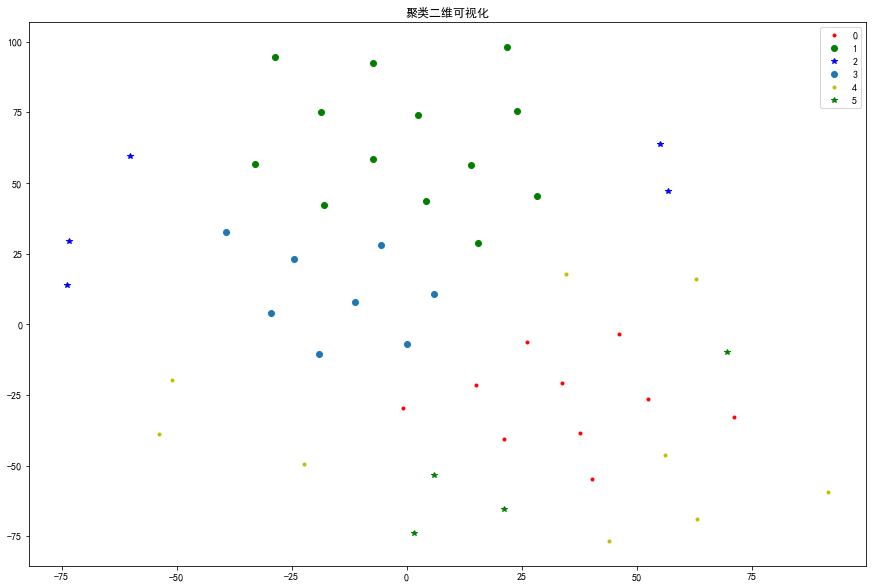

In [11]:
from sklearn.manifold import TSNE


t_sne = TSNE()
t_sne.fit(x)
t_sne = pd.DataFrame(t_sne.embedding_, index=data.index)

r = pd.concat([data, pd.Series(model.labels_, index=data.index)], axis=1)
r.columns = list(data.columns) + ['聚类类别']
r.to_excel('./excel/result/2/k-means_铅钡.xlsx')
plt.figure(figsize=(15,10))

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


dd = t_sne[r[u'聚类类别'] == 0]
plt.plot(dd[0], dd[1], 'r.',label=0)
dd = t_sne[r[u'聚类类别'] == 1]
plt.plot(dd[0], dd[1], 'go',label=1)
dd = t_sne[r[u'聚类类别'] == 2]
plt.plot(dd[0], dd[1], 'b*',label=2)
dd = t_sne[r[u'聚类类别'] == 3]
plt.plot(dd[0], dd[1], 'o',label=3)

dd = t_sne[r[u'聚类类别'] == 4]
plt.plot(dd[0], dd[1], 'y.',label=4)
dd = t_sne[r[u'聚类类别'] == 5]
plt.plot(dd[0], dd[1], 'g*',label=5)
plt.title('聚类二维可视化')
plt.legend()

plt.savefig('./excel/result/2/k-means_铅钡.png')
plt.show()